# Evasion

> Attacks against classification models that construct special inputs (a.k.a adversarial examples) that appear natural to a human but are misclassified by the model.

In [1]:
#| default_exp evasion

In [2]:
#| hide
from nbdev.showdoc import *

In [3]:
#| export
from abc import ABC, abstractclassmethod, abstractmethod
from typing import Callable, Type

import torch
from torch import nn
from fastai.vision.all import *


class Perturber(ABC, nn.Module):
    "Perturbs inputs. Perturbations are bounded under some metric (e.g. some norm). Meant to be subclassed and then passed to `AdversarialExamplesAttack`"
    def __init__(self, epsilon, x, rand_init):
        super().__init__()
        self.epsilon = epsilon
        self.p = nn.Parameter(self.rand_init(epsilon, x.shape) if rand_init else torch.zeros(x.shape))
        self.clamp_pixel_values(x)

    def forward(self, x):
        return x + self.p    

In [4]:
#| export
@patch(cls_method=True)
@abstractmethod
def rand_init(cls: Perturber, epsilon, shape):
    "Initialize a random perturbation"
    ...

In [5]:
#| export
@patch
@abstractmethod
def clamp_pixel_values(self: Perturber, x):
    "Clamp peturbation such that perturbing `x` maintains valid pixel values"
    ...

In [6]:
#| export
@patch
@abstractmethod
def callback(self: Perturber) -> Callback:
    "Return a callback in charge of affecting the training loop (e.g. clamping the perturbation after an optimization step, steepest descent, etc.)"
    ...

In [7]:
#| export
class LinfPerturber(Perturber):
    "Perturbs inputs under a bounded $l_\infty$ norm"
    @classmethod
    def rand_init(cls, epsilon, shape):
        return torch.rand(shape) * epsilon
    
    def clamp_pixel_values(self, x):
        with torch.no_grad():
            x = x.to(self.p.device)
            self.p.data = (x + self.p).clamp(0., 1.) - x

    def callback(self):
        class ProjectionCallback(Callback):
            def before_step(inner_self):
                with torch.no_grad():
                    self.p.grad.sign_()

            def after_batch(inner_self):
                with torch.no_grad():
                    self.p.clamp_(-self.epsilon, self.epsilon)  # keep perturbation small
                    self.clamp_pixel_values(inner_self.x)

        return ProjectionCallback()


In [8]:
#| export
class AdversarialExamplesAttack(object):
    "Constructs adversarial examples: slightly perturbed inputs that fool classification models"
    def __init__(self,
                 model: Module,
                 loss: Callable = CrossEntropyLossFlat(),
                 perturber_type: Type[Perturber] = LinfPerturber,
                 targeted: bool = False,  # Whether the constructed inputs should be classified as the specified targets or not
                 min_delta: float = 1e-2,  # Minimum loss delta for `ReduceLROnPlateau` and `EarlyStoppingCallback`
                 min_lr: float = 1e-6,  # Minimum lr for `ReduceLROnPlateau`
                 lr: float = None,  # pass `None` to pick `lr` based on other params
                 # defaults taken from advertorch
                 epsilon: float = 0.3,
                 epoch_size: int = 10,  # Affects how often epoch-callbacks are called (e.g. `Recorder`` and `EarlyStoppingCallback`)
                 n_epochs: int = 4,
                 rand_init: bool = True):
        self.loss = loss if targeted else (lambda *args, **kwargs: -loss(*args, **kwargs))
        self.lr = lr or (epsilon / epoch_size)
        store_attr('model, perturber_type, min_delta, min_lr, epsilon, epoch_size, n_epochs, rand_init')

    def perturb(self, dsets):
        x, y = dsets.load()
        x, y = x.detach().clone(), y.detach().clone()  # TODO: can I get rid of this?
        self.model.eval()
        self.model.requires_grad_(False)

        perturber = self.perturber_type(self.epsilon, x, self.rand_init)

        class TrainLoop(TrainEvalCallback):
            def before_train(self):
                super().before_train()
                self.model.eval()

            def before_validate(self):
                raise CancelValidException

        learner = Learner(DataLoaders([(x, y) for _ in range(self.epoch_size)], []),
                          nn.Sequential(perturber, self.model),
                          self.loss,
                          SGD,
                          self.lr,
                          train_bn=False,
                          default_cbs=False,
                          cbs=[TrainLoop, Recorder(valid_metrics=False), ProgressCallback, BnFreeze,
                               perturber.callback(),
                               ReduceLROnPlateau('train_loss', min_delta=self.min_delta, min_lr=self.min_lr),
                               EarlyStoppingCallback('train_loss', min_delta=self.min_delta / 10)
                               ])
        learner.fit(self.n_epochs)
        p = perturber.p.data.detach().cpu()
        return Datasets(tls=[TfmdLists(x.cpu() + p, ToTensor()),  # ToTensor for decoding
                             dsets.tls[1]])

In [9]:
show_doc(AdversarialExamplesAttack.perturb)

---

### AdversarialExamplesAttack.perturb

>      AdversarialExamplesAttack.perturb (dsets)

In [10]:
from fastai_datasets.all import *
from similarity_learning.all import *

In [11]:
mnist = MNIST()
classifier = MLP(10)
learn = Learner(mnist.dls(), classifier, metrics=accuracy)
learn.fit(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.172130,0.133872,0.963000,00:25


In [12]:
sub_dsets = mnist.valid.random_sub_dsets(64)

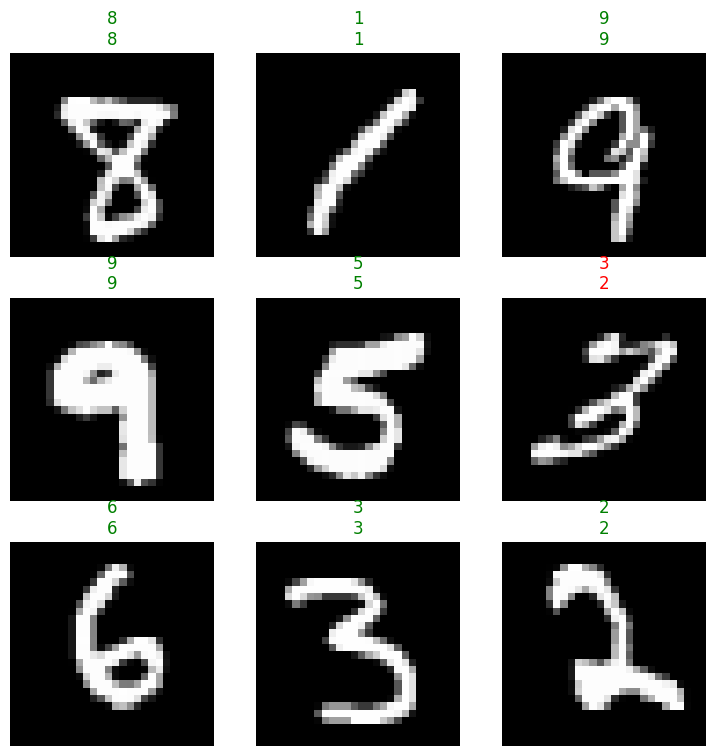

In [13]:
learn.show_results(shuffle=False, dl=sub_dsets.dl())
benign_accuracy = learn.validate(dl=sub_dsets.dl())[1]
test(benign_accuracy, .9, ge)

In [14]:
attack = AdversarialExamplesAttack(classifier, epsilon=.15, n_epochs=10)
perturbed_dsets = attack.perturb(sub_dsets)

epoch,train_loss,time
0,-3.363828,00:00
1,-5.948072,00:00
2,-7.121306,00:00
3,-7.727537,00:00
4,-8.085769,00:00
5,-8.318174,00:00
6,-8.478257,00:00
7,-8.593016,00:00
8,-8.677756,00:00
9,-8.741797,00:00


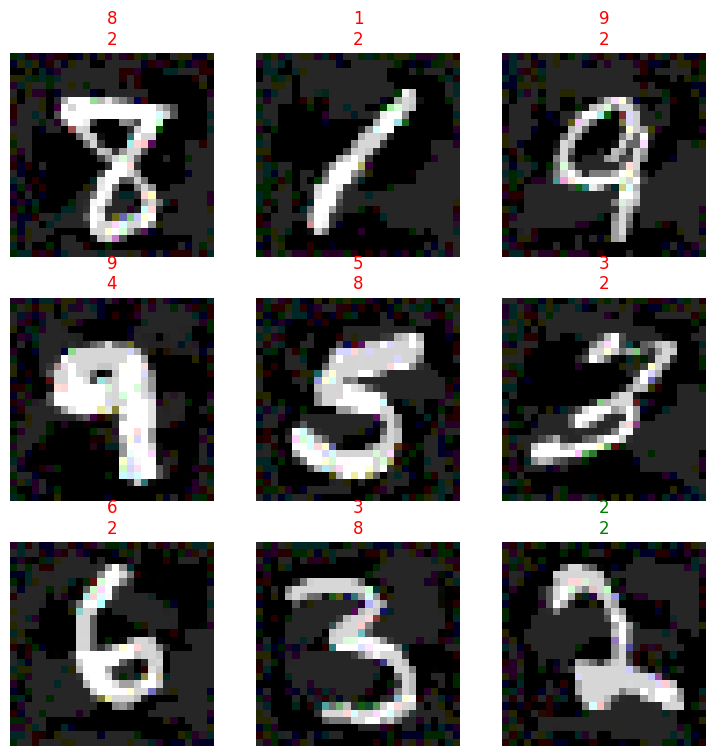

In [15]:
learn.show_results(shuffle=False, dl=TfmdDL(perturbed_dsets))
benign_accuracy = learn.validate(dl=TfmdDL(perturbed_dsets))[1]
test(benign_accuracy, .1, le)

In [16]:
#| hide
import nbdev; nbdev.nbdev_export()